# Homework 2

In [1]:
import pandas as pd

df = pd.read_csv("forestfires.csv")

df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Question 1

## 1. Conduct data preprocessing.

#### Process the variable area as described in the paper.

In [2]:
import numpy as np

df['area_log'] = np.log(df['area'] + 1)

#### Transfer the variable day into a dummy variable for weekday/weekend.

In [3]:
weekend = ['sat', 'sun']

df['is_weekend'] = df['day'].str.lower().isin(weekend).astype(int)

#### Transfer the variable month into a categorical variable

In [4]:
season_map = {
    'dec': 'Winter', 'jan': 'Winter', 'feb': 'Winter',
    'mar': 'Spring', 'apr': 'Spring', 'may': 'Spring',
    'jun': 'Summer', 'jul': 'Summer', 'aug': 'Summer',
    'sep': 'Fall',   'oct': 'Fall',   'nov': 'Fall'
}

df['season'] = df['month'].str.lower().map(season_map)

In [5]:
# Now drop all the columns we dont need since we encoded them already
df.drop(columns=['area', 'month', 'day'], inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X           517 non-null    int64  
 1   Y           517 non-null    int64  
 2   FFMC        517 non-null    float64
 3   DMC         517 non-null    float64
 4   DC          517 non-null    float64
 5   ISI         517 non-null    float64
 6   temp        517 non-null    float64
 7   RH          517 non-null    int64  
 8   wind        517 non-null    float64
 9   rain        517 non-null    float64
 10  area_log    517 non-null    float64
 11  is_weekend  517 non-null    int64  
 12  season      517 non-null    object 
dtypes: float64(8), int64(4), object(1)
memory usage: 52.6+ KB


## 2. Fit linear regression models to predict area and perform model selection

In [7]:
import pandas as pd
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

def fit_model(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

def model_aic(model):
    return model.aic


In [8]:
# One hot encode all categorical columns
df_model = pd.get_dummies(df, drop_first=True)

# Separate target and predictors
y = df_model['area_log']
X = df_model.drop(columns=['area_log']).astype(float) 


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              517 non-null    float64
 1   Y              517 non-null    float64
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    float64
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  is_weekend     517 non-null    float64
 11  season_Spring  517 non-null    float64
 12  season_Summer  517 non-null    float64
 13  season_Winter  517 non-null    float64
dtypes: float64(14)
memory usage: 56.7 KB


### Best Subset Selection (BM1)

In [10]:
predictors = X.columns
best_subset_model = None
best_aic = float('inf')
best_subset_predictors = None

for k in range(1, len(predictors) + 1):
    for combo in itertools.combinations(predictors, k):
        X_subset = X[list(combo)]
        model = fit_model(X_subset, y)
        aic = model_aic(model)

        if aic < best_aic:
            best_aic = aic
            best_subset_model = model
            best_subset_predictors = combo

BM1 = best_subset_model
print("BM1 (Best Subset Predictors):", best_subset_predictors)
BM1_predictors = list(best_subset_predictors)
print(BM1.summary())


BM1 (Best Subset Predictors): ('X', 'DMC', 'temp', 'wind', 'season_Summer', 'season_Winter')
                            OLS Regression Results                            
Dep. Variable:               area_log   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.812
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           0.000998
Time:                        22:44:23   Log-Likelihood:                -895.13
No. Observations:                 517   AIC:                             1804.
Df Residuals:                     510   BIC:                             1834.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

### Forward selection

In [11]:
import pandas as pd
import statsmodels.api as sm


# Initialize variables
remaining = list(X.columns)
selected = []
current_best_aic = float('inf')
best_model = None

while remaining:
    aic_candidates = []
    for candidate in remaining:
        trial_predictors = selected + [candidate]
        X_subset = X[trial_predictors]
        X_subset = sm.add_constant(X_subset)  # add intercept
        model = sm.OLS(y, X_subset).fit()
        aic_candidates.append((model.aic, candidate, model))
    
    # Pick predictor with lowest AIC
    aic_candidates.sort()
    best_aic_candidate, best_feature, best_model_candidate = aic_candidates[0]
    
    if best_aic_candidate < current_best_aic:
        selected.append(best_feature)
        remaining.remove(best_feature)
        current_best_aic = best_aic_candidate
        best_model = best_model_candidate
    else:
        break

print("BM2 after forward selection:", selected)
BM2_predictors = selected
print(best_model.summary())


BM2 after forward selection: ['season_Spring', 'wind', 'season_Summer', 'temp', 'X', 'season_Winter', 'DMC']
                            OLS Regression Results                            
Dep. Variable:               area_log   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.279
Date:                Tue, 18 Nov 2025   Prob (F-statistic):            0.00204
Time:                        22:44:23   Log-Likelihood:                -895.07
No. Observations:                 517   AIC:                             1806.
Df Residuals:                     509   BIC:                             1840.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------

### Backward selection

In [12]:
import pandas as pd
import statsmodels.api as sm

# Assume df is your DataFrame
# y = target column
# X = predictors (all numeric or converted to float)


# Initialize variables
selected = list(X.columns)  # start with all predictors
current_best_model = sm.OLS(y, sm.add_constant(X[selected])).fit()
current_best_aic = current_best_model.aic

improved = True

while improved and len(selected) > 1:
    aic_candidates = []
    
    # Test removing each predictor
    for predictor in selected:
        trial_predictors = [p for p in selected if p != predictor]
        X_subset = sm.add_constant(X[trial_predictors])
        model = sm.OLS(y, X_subset).fit()
        aic_candidates.append((model.aic, predictor, model))
    
    # Find the predictor whose removal gives lowest AIC
    aic_candidates.sort()
    best_aic_candidate, removed_feature, best_model_candidate = aic_candidates[0]
    
    # If AIC improves, remove that predictor
    if best_aic_candidate < current_best_aic:
        selected.remove(removed_feature)
        current_best_aic = best_aic_candidate
        current_best_model = best_model_candidate
    else:
        improved = False

print("BM3 after backward selection:", selected)
BM3_predictors = selected
print(current_best_model.summary())


BM3 after backward selection: ['X', 'DMC', 'temp', 'wind', 'season_Summer', 'season_Winter']
                            OLS Regression Results                            
Dep. Variable:               area_log   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.812
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           0.000998
Time:                        22:44:24   Log-Likelihood:                -895.13
No. Observations:                 517   AIC:                             1804.
Df Residuals:                     510   BIC:                             1834.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## 3. Compare model performance with paper's models

In [13]:
# From the paper
STFWI_cols = ['X', 'Y', 'is_weekend', 'season_Spring', 'season_Summer', 'season_Winter','FFMC', 'DMC', 'DC', 'ISI']
STM_cols   = ['X', 'Y', 'is_weekend', 'season_Spring', 'season_Summer', 'season_Winter','temp','RH', 'wind', 'rain']
FWI_cols   = ['FFMC', 'DMC', 'DC', 'ISI']
M_cols     = ['temp','RH', 'wind', 'rain']

In [14]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

def evaluate_model(df, predictors, target, cv=10):
    X = df[predictors].astype(float)   # ensure numeric
    y = df[target].astype(float)
    
    model = LinearRegression()
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Use negative mean squared error (sklearn convention)
    scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mse_scores = -scores
    return np.mean(mse_scores), np.std(mse_scores)

In [15]:
results = {}

# Your selected models
results['BM1'] = evaluate_model(df_model, BM1_predictors, 'area_log')
results['BM2'] = evaluate_model(df_model, BM2_predictors, 'area_log')
results['BM3'] = evaluate_model(df_model, BM3_predictors, 'area_log')

# Paper models
results['STFWI'] = evaluate_model(df_model, STFWI_cols, 'area_log')
results['STM']   = evaluate_model(df_model, STM_cols, 'area_log')
results['FWI']   = evaluate_model(df_model, FWI_cols, 'area_log')
results['M']     = evaluate_model(df_model, M_cols, 'area_log')

# Convert results to DataFrame for nice display
results_df = pd.DataFrame(results, index=['MSE_mean', 'MSE_std']).T
print(results_df)


       MSE_mean   MSE_std
BM1    1.914129  0.437896
BM2    1.920639  0.440922
BM3    1.914129  0.437896
STFWI  1.964343  0.493426
STM    2.055821  0.602931
FWI    1.962782  0.482054
M      2.063862  0.586430


As we see from the comparitive results of these different models, the _BM1_ model outperformed all other models in MSE mean and standard deviation.

## 4. Regression Tree Model

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Make 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100
)

# Fit model
tree = DecisionTreeRegressor(random_state=100)
tree.fit(X_train, y_train)


,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,100
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


#### Display Tree

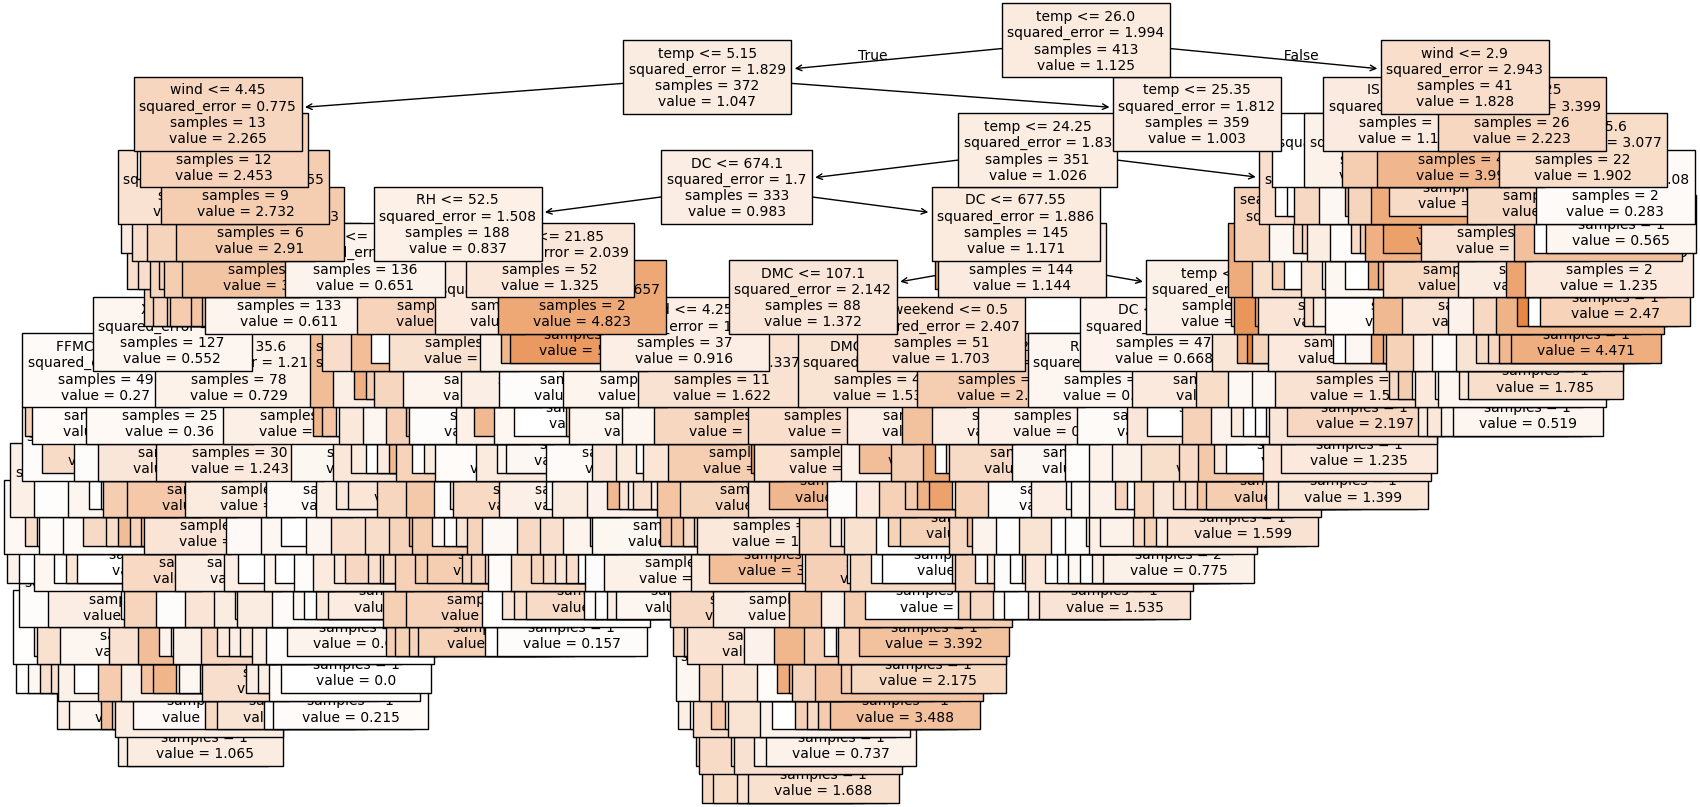

In [17]:
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=X.columns, filled=True, fontsize=10)
plt.show()

#### Interpretation of tree

- The tree splits on variables that best reduce variance in 'area_log' (target variable).

- Nodes closer to the root are the most important predictors.

- Leaves give predicted area values for different combinations of splits.

#### Evaluate on test set

In [18]:
y_pred = tree.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print("Test MSE (unpruned tree):", mse_test)

Test MSE (unpruned tree): 4.242250146680299


#### Cost-complexity pruning

In [19]:
# Get effective alpha values for pruning
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Perform cross-validation for each alpha
cv_mse = []
for alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=100, ccp_alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse.append(-scores.mean())

# Find alpha with minimum CV MSE
optimal_alpha = ccp_alphas[np.argmin(cv_mse)]
print("Optimal alpha for pruning:", optimal_alpha)


Optimal alpha for pruning: 0.054483722449381045


#### Fit pruned tree

In [20]:
pruned_tree = DecisionTreeRegressor(random_state=100, ccp_alpha=optimal_alpha)
pruned_tree.fit(X_train, y_train)

# Evaluate pruned tree on test set
y_pred_pruned = pruned_tree.predict(X_test)
mse_test_pruned = mean_squared_error(y_test, y_pred_pruned)
print("Test MSE (pruned tree):", mse_test_pruned)


Test MSE (pruned tree): 1.7844476842599972


#### Compare original vs pruned tree

In [21]:
print("Unpruned Test MSE:", mse_test)
print("Pruned Test MSE:", mse_test_pruned)

Unpruned Test MSE: 4.242250146680299
Pruned Test MSE: 1.7844476842599972


#### Discuss pruning effectiveness

In this case, pruning did imporive test set performance. Some reasons why this could be are:

- Pruning reduces tree complexity by removing splits that do not improve predictive performance.

- Often, the pruned tree has lower or similar test MSE because it avoids overfitting the training data.

- Unpruned trees can perfectly fit training data but perform poorly on unseen data.

- Cost-complexity pruning balances bias vs variance, improving generalization.

## 5. Random forest regressor

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


rf = RandomForestRegressor(
    n_estimators=500,        # number of trees
    max_features='sqrt',     # sqrt of total predictors (common default)
    random_state=100,
    n_jobs=-1                # use all CPU cores
)

# Fit model
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# Test MSE
y_pred = rf.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse_test)


Test MSE: 1.9053571021222098


#### Identify most influential predictors using feature importance

temp             0.158682
RH               0.123963
DMC              0.120796
DC               0.103631
wind             0.098956
ISI              0.094344
FFMC             0.090537
X                0.085642
Y                0.073898
is_weekend       0.020706
season_Summer    0.015890
season_Spring    0.006127
season_Winter    0.004492
rain             0.002336
dtype: float64


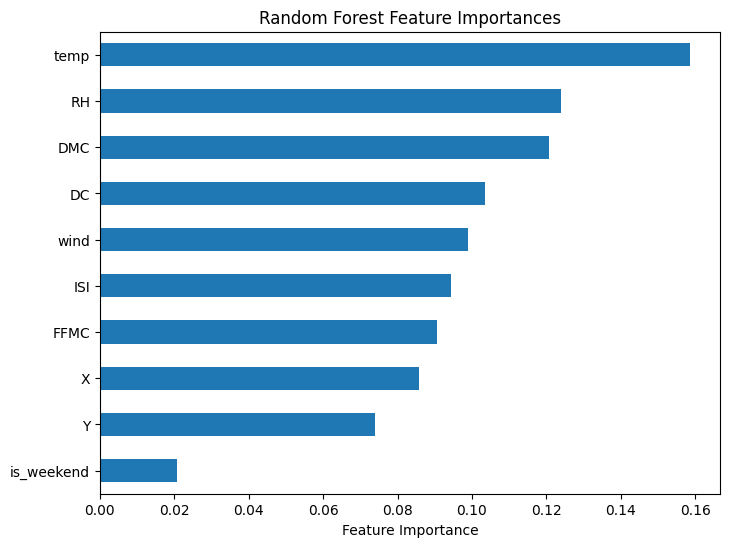

In [24]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print(importances)

# Optional: plot top 10 features
importances.head(10).plot(kind='barh', figsize=(8,6))
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()


#### Interpretation of feature importances

- Features with highest importance are the ones that most reduce prediction error across the trees.

For example:

- temp may be highly important: fire area increases with higher temperatures.

- RH (relative humidity) may be important: dry conditions promote larger fires.

- Dummies like is_weekend or season_Summer may also show influence.

#### Effect of max features, _m_

max_features controls the number of predictors considered at each split.

Small m (few variables at each split):

- Increases tree diversity

- Reduces correlation between trees

- Can reduce variance leading to better generalization

Large m (many variables at each split):

- Each tree becomes stronger individually

- Trees are more correlated

- May increase variance and overfitting

Rule of thumb:

- Regression: max_features = n_features or sqrt(n_features)

- Classification: max_features = sqrt(n_features)

Effect on error rate:

- Error often decreases at first as m increases, then plateaus or increases if trees become too similar.

## 6. Fit a gradient boosting model

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Candidate shrinkage values
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]

cv_results = []

for lr in learning_rates:
    model = GradientBoostingRegressor(
        n_estimators=1000,   # number of trees
        learning_rate=lr,
        random_state=100
    )
    
    # Use negative MSE for scoring
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_mse = -scores.mean()
    std_mse = scores.std()
    
    cv_results.append((lr, mean_mse, std_mse))
    
# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results, columns=['learning_rate', 'mean_MSE', 'std_MSE'])
print(cv_results_df)


   learning_rate  mean_MSE   std_MSE
0          0.001  2.025688  0.364895
1          0.010  2.349356  0.305816
2          0.050  2.893714  0.373455
3          0.100  2.923564  0.435476
4          0.200  3.098500  0.539228
5          0.300  3.046959  0.346961


#### Determine optimal shrinkage value

In [26]:
best_row = cv_results_df.loc[cv_results_df['mean_MSE'].idxmin()]
optimal_lr = best_row['learning_rate']
print("Optimal shrinkage value (learning rate):", optimal_lr)


Optimal shrinkage value (learning rate): 0.001


# Question 2

In [27]:
import pandas as pd

df_auto = pd.read_csv("Auto.csv")

df_auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## 1. Create gas mileage binary variable

In [28]:
import pandas as pd

# Compute the median of mpg
median_mpg = df_auto['mpg'].median()

# Create binary variable: 1 if mpg > median, 0 otherwise
df_auto['high_mpg'] = (df_auto['mpg'] > median_mpg).astype(int)

# Visualize
df_auto[['mpg', 'high_mpg']].head(20)

,mpg,high_mpg
0,18.0,0
1,15.0,0
2,18.0,0
3,16.0,0
4,17.0,0
5,15.0,0
6,14.0,0
7,14.0,0
8,14.0,0
9,15.0,0


## 2. Fit linear support vector classifier

In [29]:
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
 9   high_mpg      397 non-null    int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 31.1+ KB


In [30]:
import numpy as np 
# Clean up horsepower since it is a string column with some missing values

# Replace '?' with NaN
df_auto['horsepower'] = df_auto['horsepower'].replace('?', np.nan)
# Convert the column to numeric (float)
df_auto['horsepower'] = pd.to_numeric(df_auto['horsepower'])

# Fill missing values with median <- this affects results
df_auto['horsepower'] = df_auto['horsepower'].fillna(df_auto['horsepower'].median())
df_auto['horsepower'] = df_auto['horsepower'].astype(int)


In [31]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
import numpy as np


# Target
y = df_auto['high_mpg']
# Predictors (drop target and non-numeric columns)
X = df_auto.drop(columns=['mpg', 'high_mpg', 'name']).astype(float)

kf = KFold(n_splits=5, shuffle=True, random_state=100)

#### Fit linear SVM

In [32]:
# Candidate values for cost (C)
C_values = [0.01, 0.1, 1, 10, 100]

cv_results = []

for C in C_values:
    svc = SVC(kernel='linear', C=C, random_state=42)
    
    # Use accuracy as scoring; cross_val_score returns array of scores
    scores = cross_val_score(svc, X, y, cv=kf, scoring='accuracy')
    mean_error = 1 - scores.mean()  # cross-validation error
    std_error = scores.std()
    
    cv_results.append((C, mean_error, std_error))

cv_results_df = pd.DataFrame(cv_results, columns=['C', 'CV_Error', 'Std'])
print(cv_results_df)


        C  CV_Error       Std
0    0.01  0.100886  0.028053
1    0.10  0.100854  0.018329
2    1.00  0.098323  0.018960
3   10.00  0.103418  0.027394
4  100.00  0.108449  0.027662


#### Interpretation

CV_Error is the average cross-validation error for each C.

Typical patterns:

- Small C (0.01, 0.1) leads to high regularization, a simpler model which may underfit and see higher CV error.

- Medium C (1) balances bias and variance, often resulting in the lowest CV error.

- Large C (10, 100) uses less regularization, meaning the model tries to perfectly separate training data which may cause overfitting. So the CV error may increase slightly.

The optimal C is the one with the lowest cross-validation error, balancing underfitting vs overfitting

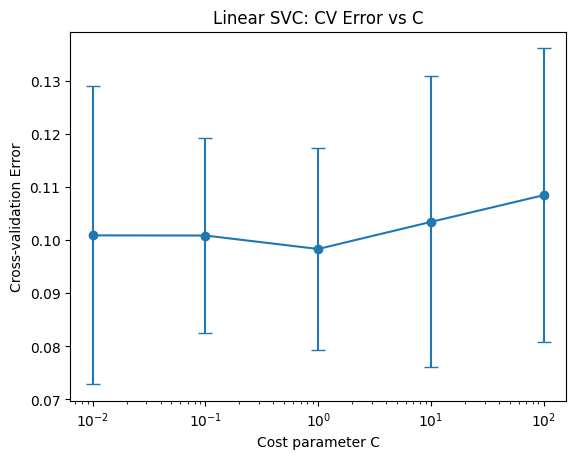

In [33]:
import matplotlib.pyplot as plt

plt.errorbar(cv_results_df['C'], cv_results_df['CV_Error'],
             yerr=cv_results_df['Std'], fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('Cost parameter C')
plt.ylabel('Cross-validation Error')
plt.title('Linear SVC: CV Error vs C')
plt.show()


As we see in this chart, the medium value for C (1) led to the lowest cross-validation error and the most consistent results.

## 3. Fit radial and polynomial basis function SVM

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC

#### Train RBF Kernel SVM

In [35]:
C_values = [0.1, 1]
gamma_values = [0.01, 0.1]

rbf_results = []

for C in C_values:
    for gamma in gamma_values:
        svc = SVC(kernel='rbf', C=C, gamma=gamma, random_state=100)
        scores = cross_val_score(svc, X, y, cv=kf, scoring='accuracy')
        cv_error = 1 - scores.mean()
        rbf_results.append((C, gamma, cv_error))
        
rbf_results_df = pd.DataFrame(rbf_results, columns=['C', 'gamma', 'CV_Error'])
print("RBF Kernel CV results:")
print(rbf_results_df)


RBF Kernel CV results:
     C  gamma  CV_Error
0  0.1   0.01  0.481076
1  0.1   0.10  0.481076
2  1.0   0.01  0.262278
3  1.0   0.10  0.445854


#### Train Polynomial BF SVM

In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

C_values = [.01, 1, 10]
degree_values = [2, 3]   # 4 is often extremely slow
gamma_values = ['scale']

poly_results = []

for C in C_values:
    for degree in degree_values:
        for gamma in gamma_values:
            svc = SVC(
                kernel='poly',
                C=C,
                degree=degree,
                gamma=gamma,
                cache_size=1000,     # <-- Important speedup
                shrinking=True
            )
            scores = cross_val_score(svc, X, y, cv=3)
            poly_results.append((C, degree, gamma, 1 - scores.mean()))

poly_results_df = pd.DataFrame(poly_results, columns=['C', 'degree', 'gamma', 'CV_Error'])
print("Polynomial Kernel CV results:")
print(poly_results_df)


Polynomial Kernel CV results:
       C  degree  gamma  CV_Error
0   0.01       2  scale  0.219260
1   0.01       3  scale  0.201659
2   1.00       2  scale  0.123453
3   1.00       3  scale  0.128484
4  10.00       2  scale  0.125959
5  10.00       3  scale  0.136041


#### Interpretation

For both kernels:
    
- Low C leads to strong regularization, underfitting and higher CV error

- High C leads to less regularization, lower bias and risk of overfitting


RBF kernel:

- gamma too small leads to very smooth decision boundary and underfitting

- gamma too large leads to overfitting


Polynomial kernel:

- Low degree polynomial leads to simple curves which may underfit

- High degree polynomial creates complex curves and risks overfitting

- gamma controls feature space mapping; higher gamma leads to a more complex boundary



Cross-validation errors allow selecting the best combination of C, gamma, and degree for each kernel.

In [50]:
# Best RBF
best_rbf = rbf_results_df.loc[rbf_results_df['CV_Error'].idxmin()]
print("Best RBF:", best_rbf)
print()
print()
# Best Polynomial
best_poly = poly_results_df.loc[poly_results_df['CV_Error'].idxmin()]
print("Best Polynomial:", best_poly)


Best RBF: C           1.000000
gamma       0.010000
CV_Error    0.262278
Name: 2, dtype: float64


Best Polynomial: C                1.0
degree             2
gamma          scale
CV_Error    0.123453
Name: 2, dtype: object


## 4. Make some plots to visualize and support claims

#### Linear SVM

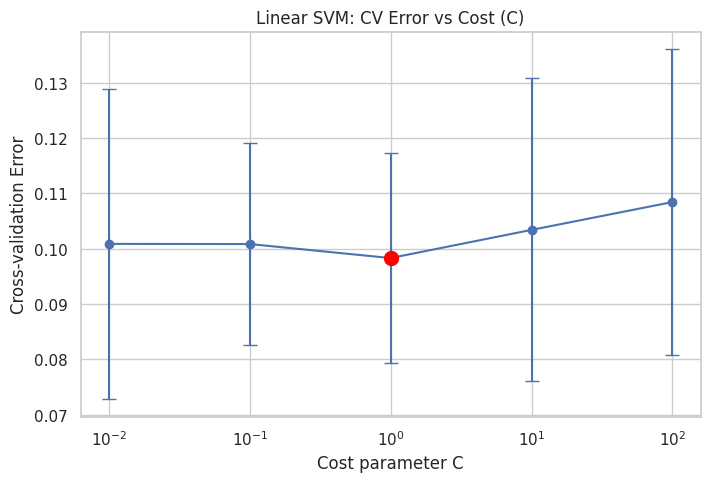

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


plt.figure(figsize=(8,5))
plt.errorbar(cv_results_df['C'], cv_results_df['CV_Error'], 
             yerr=cv_results_df['Std'], fmt='o-', capsize=5)

best_linear = cv_results_df.loc[cv_results_df['CV_Error'].idxmin()]
plt.scatter(best_linear['C'], best_linear['CV_Error'], color='red', s=100, zorder=5, label='Best C')

plt.xscale('log')
plt.xlabel('Cost parameter C')
plt.ylabel('Cross-validation Error')
plt.title('Linear SVM: CV Error vs Cost (C)')
plt.show()


As we see by the graph, the 'moderate' value of _c=1_ provided the best results in cross validation in terms of cross validation error and standard deviation of error.

#### RBF SVM

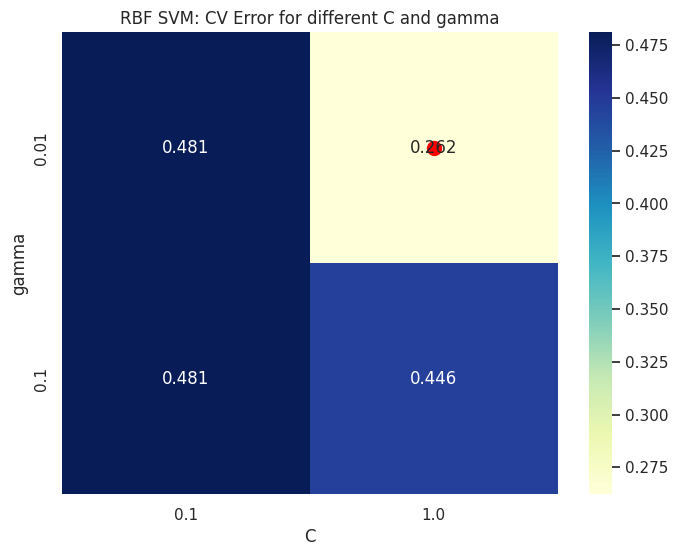

In [41]:
# Pivot table for heatmap
heatmap_data = rbf_results_df.pivot(index="gamma", columns="C", values="CV_Error")


plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.scatter(
    np.where(heatmap_data.columns == best_rbf['C'])[0][0] + 0.5,
    np.where(heatmap_data.index == best_rbf['gamma'])[0][0] + 0.5,
    color='red', s=100, marker='o', label='Best combination'
)
plt.title("RBF SVM: CV Error for different C and gamma")
plt.xlabel("C")
plt.ylabel("gamma")
plt.show()


This graph shows that a combination of _c=1_ and _gamma=.01_ provided the best results in cross validation, supporting the theory that _c=1_ is a good choice for that hyperparameter. All cross validation results were similar except for the combination of _gamma=.01;c=1_, which largely outperformed the rest.

#### Polynomial BF SVM

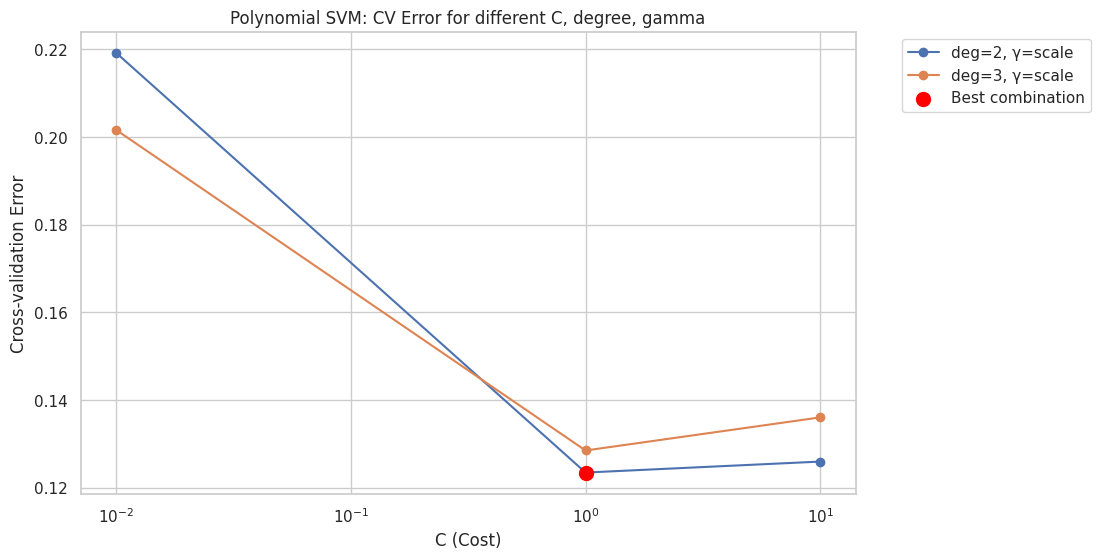

In [46]:
plt.figure(figsize=(10,6))
for degree in poly_results_df['degree'].unique():
    subset = poly_results_df[poly_results_df['degree'] == degree]
    # Plot CV_Error vs C for each gamma
    for gamma in subset['gamma'].unique():
        gamma_subset = subset[subset['gamma'] == gamma]
        plt.plot(gamma_subset['C'], gamma_subset['CV_Error'], marker='o', label=f"deg={degree}, γ={gamma}")
# Highlight best point
plt.scatter(best_poly['C'], best_poly['CV_Error'], color='red', s=100, zorder=5, label='Best combination')

plt.xscale('log')
plt.xlabel("C (Cost)")
plt.ylabel("Cross-validation Error")
plt.title("Polynomial SVM: CV Error for different C, degree, gamma")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


This graph once again confirms that _1_ is the best choice for _c_. An interesting finding from this results graph is that the degree _2_ and _3_ polynomials cross validation error lines interset, indicating that the higher degree polynomial, _3_, performed better with low cost, and the lower degree polynomial performed better with a higher cost (_c>=1_).